# Speech Emotion Recognition

## Data Preprocessing

---

### Imports

In [44]:
import os

import librosa, librosa.display
import IPython.display as ipd
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm

### Define Constants

In [45]:
# path constants
DATA_PATH = '../data/'
RAW_DATA_PATH = DATA_PATH + 'Audio_Speech_Actors_01-24/'
DF_ALL_PATH = DATA_PATH + 'df_all.pkl'
DF_MALE_PATH = DATA_PATH + 'df_male.pkl'
DF_FEMALE_PATH = DATA_PATH + 'df_female.pkl'

DF_ALL_AUG_PATH = DATA_PATH + 'df_all_aug.pkl'

# audio constants
SAMPLE_RATE = 22050

# signal duration
SIGNAL_DURATION = 2.9

### Create a dataframe

#### Load data

In [46]:
dir_path = RAW_DATA_PATH
dir_list = os.listdir(dir_path)
dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


#### Declaring the labels

In [47]:
emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
intensity_list = ['normal', 'strong']
statement_list = ['kids', 'dogs']
gender_list = ['female', 'male']

#### Create the actual dataframe

In [48]:
columns = ['path', 'source', 'actor', 'gender', 'gender_label', 'statement', 'repetition', 'intensity', 'emotion', 'emotion_label']
data_df = pd.DataFrame(columns=columns)

count = 0
for dir in dir_list:
  file_list = os.listdir(dir_path + dir)
  for file in file_list:
    nm = file.split('.')[0].split('-')

    file_path = dir_path + dir + '/' + file
    source = int(nm[1])
    emotion = int(nm[2]) - 1
    emotion_label = emotion_list[emotion]
    intensity = int(nm[3]) - 1
    statement = int(nm[4]) - 1
    repetition = int(nm[5])
    actor = int(nm[6])
    gender = actor%2
    gender_label = gender_list[gender]

    data_df.loc[count] = [file_path, source, actor, gender, gender_label, statement, repetition, intensity, emotion, emotion_label]
    count += 1

print(len(data_df))
data_df.head(3)

1440


,path,source,actor,gender,gender_label,statement,repetition,intensity,emotion,emotion_label
0,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,1,0,0,neutral
1,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,2,0,0,neutral
2,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,1,1,0,0,neutral


### Data Exploration

In [49]:
# set plotting style for dark-themed notebook
plt.style.use('ggplot')

#### Plotting our data distribution

Text(0.5, 0, 'Emotion')

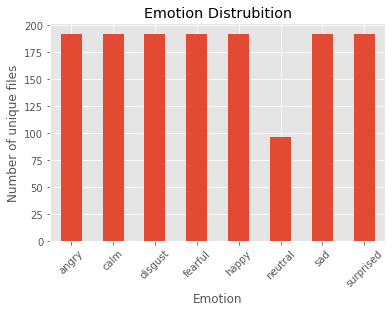

In [50]:
ax = data_df.groupby('emotion_label')['path'].nunique().plot(
    kind='bar',
    title='Emotion Distrubition',
    rot=45
)
ax.set_ylabel('Number of unique files')
ax.set_xlabel('Emotion')

#### Plotting a randomly selected file

In [51]:
# select a random example
filename = data_df.path[int(random() * len(data_df))]
print(filename)

signal, sr = librosa.load(filename, sr=SAMPLE_RATE)
ipd.Audio(signal, rate=sr)

../data/Audio_Speech_Actors_01-24/Actor_21/03-01-01-01-01-02-21.wav


In [52]:
def plot_signal(signal, title):
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    librosa.display.waveplot(signal, sr=sr)
    plt.show()

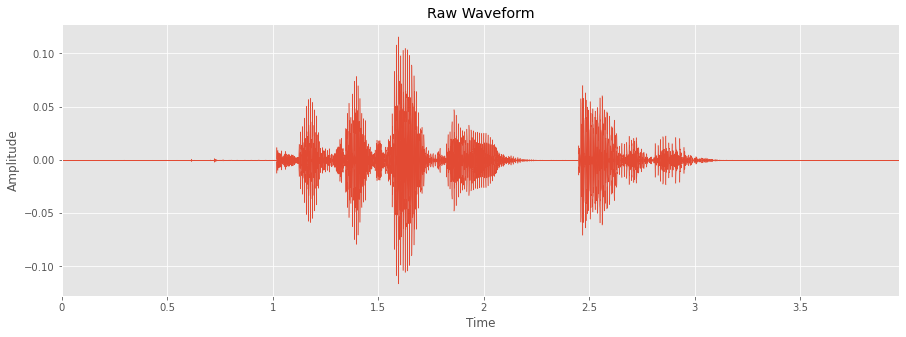

In [53]:
plot_signal(signal, 'Raw Waveform')

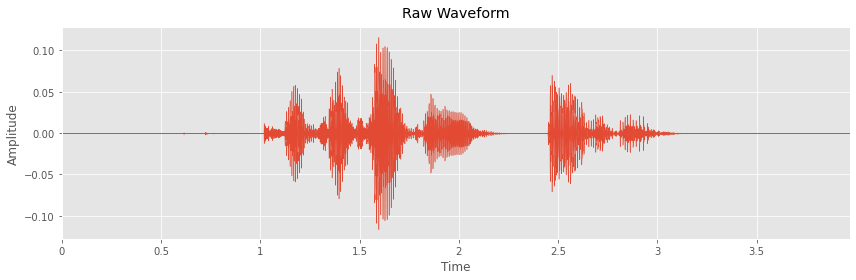

In [54]:
plt.figure(figsize=(12, 4))
plt.title("Raw Waveform", pad=10)
plt.xlabel("Time in Seconds")
plt.ylabel("Amplitude")
librosa.display.waveplot(signal, sr=sr)
plt.tight_layout()
plt.savefig('../plots/raw_waveform.png')

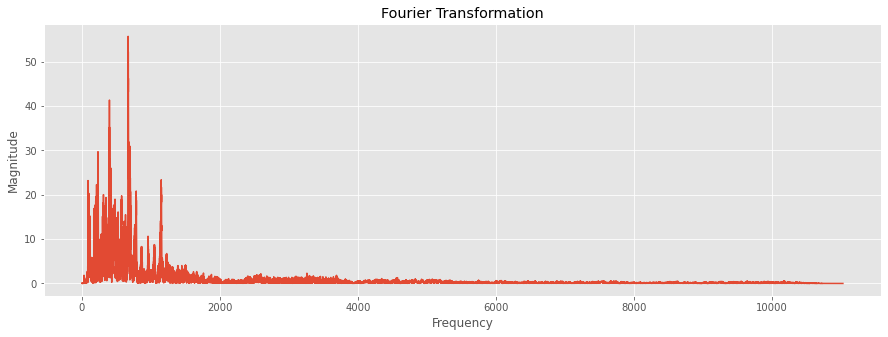

In [55]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency) / 2)]
left_magnitude = magnitude[:int(len(frequency) / 2)]

plt.figure(figsize=(15, 5))
plt.title('Fourier Transformation')
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

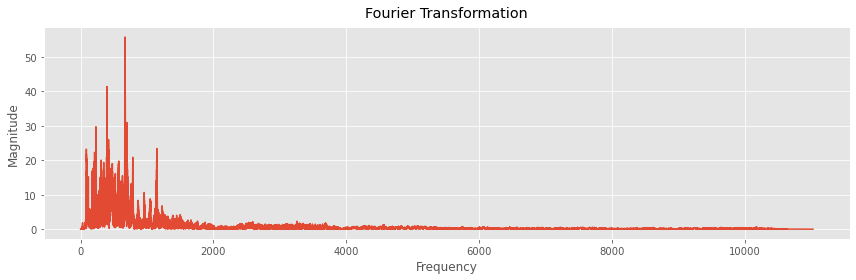

In [56]:
plt.figure(figsize=(12, 4))
plt.title("Fourier Transformation", pad=10)
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.savefig('../plots/fft.png')

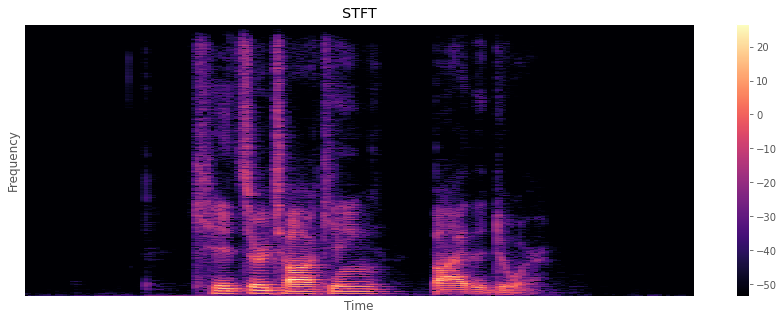

In [57]:
n_fft = 2048  # number of samples per fft
hop_length = 512  # number of samples we shift after each fft

stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(15, 5))
plt.title('STFT')
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

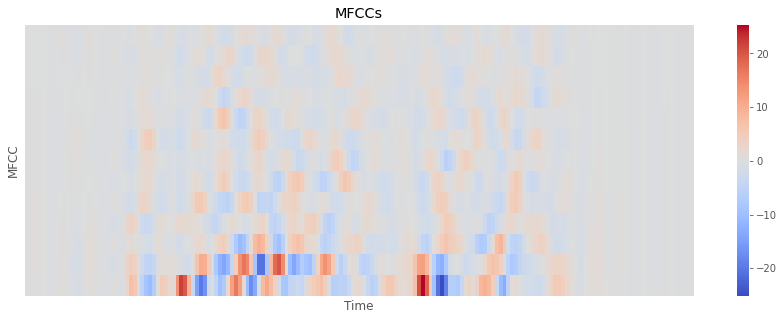

In [58]:
mfccs = librosa.feature.mfcc(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=(15, 5))
plt.title('MFCCs')
librosa.display.specshow(delta2_mfcc, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Various plots of a random trimmed file

In [59]:
trimmed_signal, bb = librosa.effects.trim(signal, top_db=30)
print(len(signal)/SAMPLE_RATE)
print(len(trimmed_signal)/SAMPLE_RATE)
ipd.Audio(trimmed_signal, rate=sr)

3.970657596371882
2.020136054421769


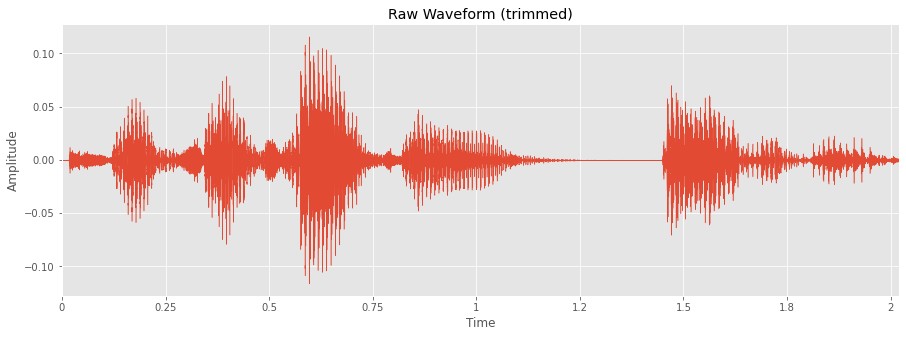

In [60]:
plot_signal(trimmed_signal, "Raw Waveform (trimmed)")

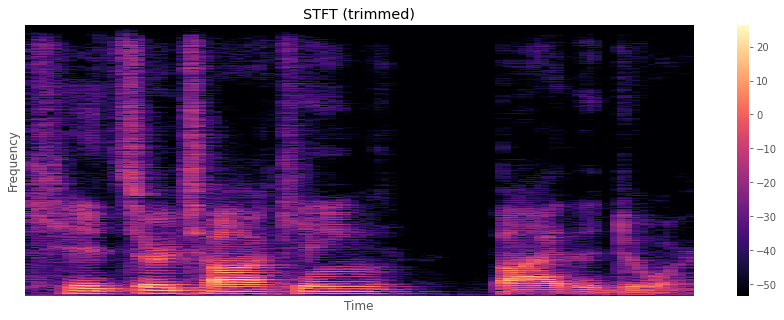

In [61]:
n_fft = 2048  # number of samples per fft
hop_length = 512  # number of samples we shift after each fft

stft = librosa.core.stft(trimmed_signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(15, 5))
plt.title('STFT (trimmed)')
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

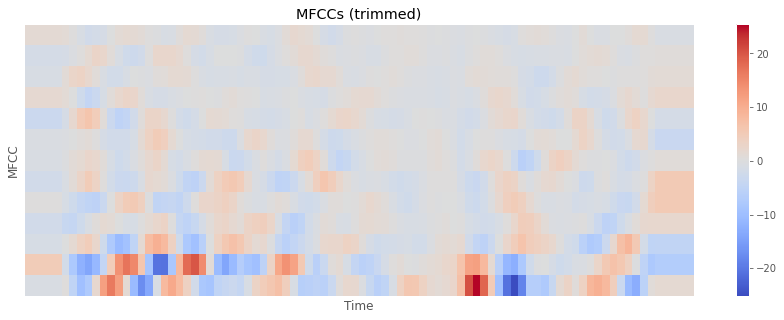

In [62]:
mfccs = librosa.feature.mfcc(trimmed_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc_trim = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=(15, 5))
plt.title('MFCCs (trimmed)')
librosa.display.specshow(delta2_mfcc_trim, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Data Augmentation

In [63]:
def add_noise(data):
    """
    Add White Noise
    :param data:
    :return:
    """
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def add_shift(data):
    """
    Add Random Shifting
    :param data:
    :return:
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

def add_pitch(data, sample_rate):
    """
    Add Random Pitch
    :param data:
    :param sample_rate:
    :return:
    """
    bins_per_octave = 12
    pitch_pm = 3
    pitch_change =  pitch_pm * 2 * (np.random.uniform(-1, 1))
    data = librosa.effects.pitch_shift(data.astype('float64'),
                                      sample_rate, n_steps=pitch_change,
                                      bins_per_octave=bins_per_octave)
    return data

In [64]:
def get_mfccs(signal, samplerate, use_delta2=False):
    mfcc = librosa.feature.mfcc(signal, sr=samplerate, n_mfcc=13, n_fft=2048, hop_length=512)

    if use_delta2:
        mfcc = librosa.feature.delta(mfcc, order=2)

    return mfcc.T.tolist()

def extract_features(df):

    mfcc_list = []

    for i in tqdm(range(len(df))):
        signal, sr = librosa.load(df.path[i], sr=SAMPLE_RATE, duration=SIGNAL_DURATION)
        mfcc_list.append(get_mfccs(signal, sr))

    df['mfcc'] = mfcc_list

    return df

def get_augmented_df(df, augmentation_style):

    mfcc_list = []
    augmented_df = df.copy()
    augmented_signal = None

    for i in tqdm(range(len(augmented_df))):
        signal, sr = librosa.load(augmented_df.path[i], sr=SAMPLE_RATE, duration=SIGNAL_DURATION)

        if augmentation_style == 'noise':
            augmented_signal = add_noise(signal)

        if augmentation_style == 'shift':
            augmented_signal = add_shift(signal)

        if augmentation_style == 'pitch':
            augmented_signal = add_pitch(signal, sr)

        mfcc_list.append(get_mfccs(augmented_signal, sr))

    augmented_df['mfcc'] = mfcc_list

    return augmented_df

In [65]:
pd.options.mode.chained_assignment = None
df_train, df_test = train_test_split(data_df, test_size=0.2)
df_train["usage"] = "train"
df_test["usage"] = "test"
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [66]:
# df_train = extract_features(df_train)
# df_test = extract_features(df_test)
# df_train_noise = get_augmented_df(df_train, 'noise')
# df_train_shift = get_augmented_df(df_train, 'shift')
# df_train_pitch = get_augmented_df(df_train, 'pitch')
#
# df_all_nsp = pd.concat([
#     df_train,
#     df_train_noise,
#     df_train_shift,
#     df_train_pitch,
#     df_test
# ], ignore_index=True).reset_index(drop=True)
#
# df_all_n = pd.concat([
#     df_train,
#     df_train_noise,
#     df_test
# ], ignore_index=True).reset_index(drop=True)
#
# print('\nSaving df_all_augmented file...')
# df_all_nsp.to_pickle(DF_ALL_AUG_PATH)
# print("File size: {} MB".format(os.path.getsize(DF_ALL_AUG_PATH) / (1024 * 1024)))

#### Selecting a random file to augment

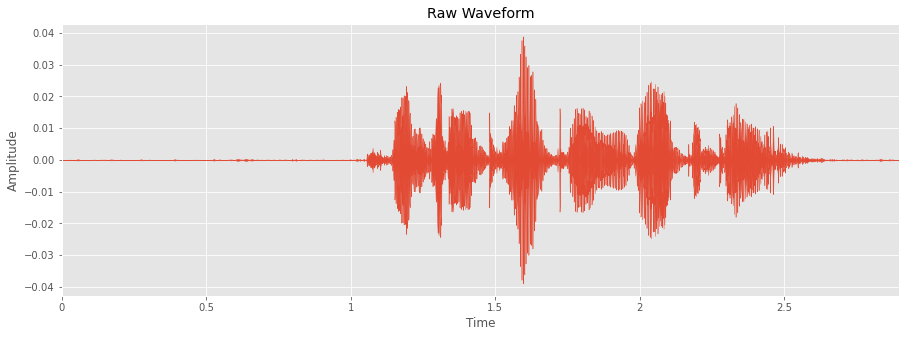

In [67]:
signal, sr = librosa.load(data_df.path[420], sr=SAMPLE_RATE, duration=SIGNAL_DURATION)
plot_signal(signal, "Raw Waveform")
ipd.Audio(signal, rate=sr)

#### Add Noise

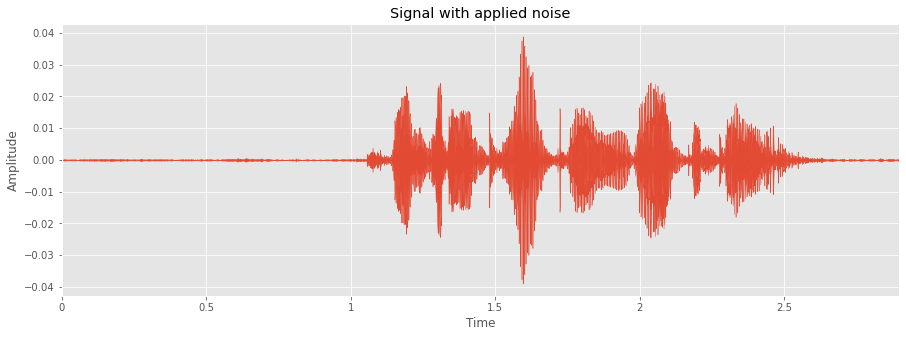

In [68]:
signal_noise = add_noise(signal)
plot_signal(signal_noise, "Signal with applied noise")
ipd.Audio(signal_noise, rate=sr)

#### Apply Time Shift

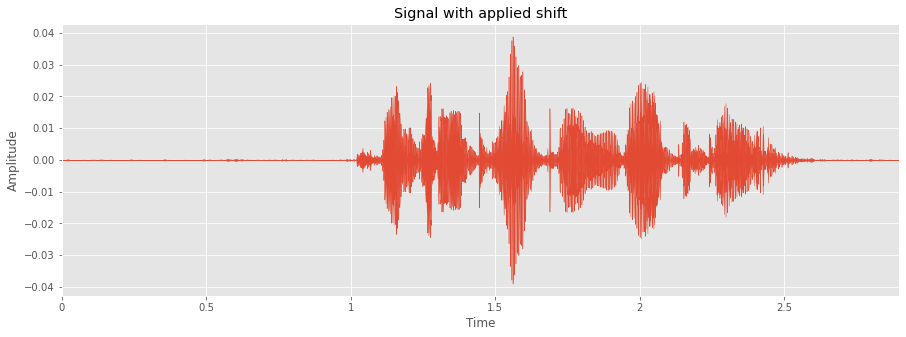

In [69]:
signal_shift = add_shift(signal)
plot_signal(signal_shift, "Signal with applied shift")
ipd.Audio(signal_shift, rate=sr)

#### Apply Pitch Shift

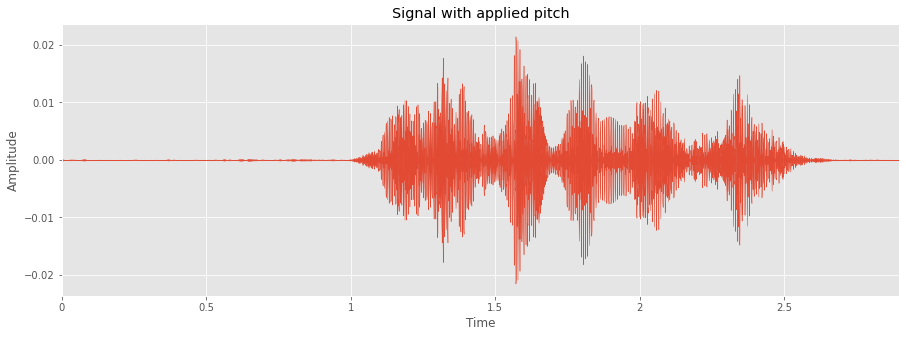

In [70]:
signal_pitch = add_pitch(signal, sample_rate=sr)
plot_signal(signal_pitch, "Signal with applied pitch")
ipd.Audio(signal_pitch, rate=sr)

### Save Feature Data Files

In [71]:
df_all_file_available = os.path.isfile(DF_ALL_PATH)
df_male_file_available = os.path.isfile(DF_MALE_PATH)
df_female_file_available = os.path.isfile(DF_FEMALE_PATH)


if not df_all_file_available:
    print("\nExtracting all features...")
    data_df = extract_features(data_df=data_df)

if not df_male_file_available:
    print("\nExtracting male features...")
    df_male = data_df[data_df['gender'] == 1]
    df_male.reset_index(inplace=True, drop=True)
    df_male = extract_features(data_df=df_male)

if not df_female_file_available:
    print("\nExtracting female features...")
    df_female = data_df[data_df['gender'] == 0]
    df_female.reset_index(inplace=True, drop=True)
    df_female = extract_features(data_df=df_female)

In [72]:
if not df_all_file_available:
    print('\nSaving df_all file...')
    data_df.to_pickle(DF_ALL_PATH)
    print("File size: {} MB".format(os.path.getsize(DF_ALL_PATH) / (1024 * 1024)))

if not df_male_file_available:
    print('\nSaving df_male file...')
    data_df.to_pickle(DF_MALE_PATH)
    print("File size: {} MB".format(os.path.getsize(DF_MALE_PATH) / (1024 * 1024)))

if not df_female_file_available:
    print('\nSaving df_female file...')
    data_df.to_pickle(DF_FEMALE_PATH)
    print("File size: {} MB".format(os.path.getsize(DF_FEMALE_PATH) / (1024 * 1024)))
